In [1]:
import json
import random
from PIL import Image, ImageDraw, ImageFont
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# @title inference function
def inference(model,
              processor,
              image_paths,
              prompt,
              sys_prompt="You are a helpful assistant.",
              max_new_tokens=1024,
              return_input=False):
    if image_paths is not None:
        images = [Image.open(img_path) for img_path in image_paths]
        image_local_paths = ["file://" + img_path for img_path in image_paths]
        content = [
            {"type": "text", "text": prompt},
        ]
        for img_path in image_local_paths:
            content.append({"image": img_path})
        messages = [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": content},
        ]
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        print("text:", text)
        # image_inputs, video_inputs = process_vision_info([messages])
        inputs = processor(text=[text], images=images, padding=True, return_tensors="pt")
    else:
        messages = [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": prompt},
        ]
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        print("text:", text)
        inputs = processor(text=[text], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    # overall_text = processor.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    # print("overall_text:", overall_text)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

[2025-06-13 01:05:52,845] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /home/tiger/.triton/autotune: No such file or directory


In [2]:
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path, padding_side="left")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


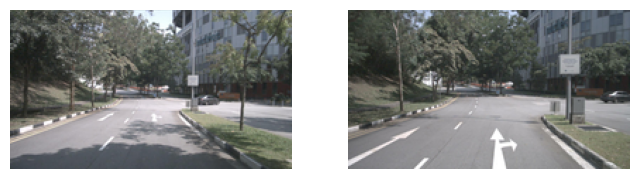

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user


       The above frames are captured from the same 3D object or 3D scene yet from different viewpoints.
        Lets patchify each frame into 9 rows and 16 columns, 
        and the origin is at the top-left corner of each frame. 
        We could index each patch by its row and col in the format of (row, col).
        Indexing range of row are of 0 ~ 8,
        indexing range of col are of 0 ~ 15.
        You are an expert of multiview stereo. try your best to answer this question:
            We could notice that the "the suv parked between poles" is centered at patch (5, 11) in the very first frame.
            Try to track the same object across all the following frames. Simply return the patch index of that object at each frame. 
            In your final answer also include the patch index of that object in the first frame.
            
        Directly reply the patch indexes in each frame in the 

In [9]:


import matplotlib.pyplot as plt


image_paths = [
      "/mnt/bn/nlhei-nas/liubangya/proj/vlm/QA/structured-data/83773bcf46ac486383529098de0542dd/1532402735948238/CAM_FRONT_raw.jpg",
      "/mnt/bn/nlhei-nas/liubangya/proj/vlm/QA/structured-data/83773bcf46ac486383529098de0542dd/1532402736897675/CAM_FRONT_raw.jpg"
    ]
prompt = '''

       The above frames are captured from the same 3D object or 3D scene yet from different viewpoints.\n        Lets patchify each frame into 9 rows and 16 columns, \n        and the origin is at the top-left corner of each frame. \n        We could index each patch by its row and col in the format of (row, col).\n        Indexing range of row are of 0 ~ 8,\n        indexing range of col are of 0 ~ 15.\n        You are an expert of multiview stereo. try your best to answer this question:\n            We could notice that the \"the suv parked between poles\" is centered at patch (5, 11) in the very first frame.\n            Try to track the same object across all the following frames. Simply return the patch index of that object at each frame. \n            In your final answer also include the patch index of that object in the first frame.\n            \n        Directly reply the patch indexes in each frame in the format of a Json list. For example:\n        [{\"frame\": xxx, \"row\": xxx, \"col\": xxx}, ..., {\"frame\": xxx, \"row\": xxx, \"col\": xxx}]. \n        Frame index starts from 0. skip the frame if the object is not visible in that frame. \n
       

'''
      

if image_paths is not None:
    images = []
    for img_path in image_paths:
        image = Image.open(img_path)
        image.thumbnail([200,200], Image.Resampling.LANCZOS)
        rgb = image.convert("RGB")
        images.append(rgb)
    # Create a grid of subplots
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    # Display each image in a subplot
    if len(images) == 1:
        axes.imshow(images[0])
        axes.axis('off')
    else:
        for i, image in enumerate(images):
            axes[i].imshow(image)
            axes[i].axis('off')
    # Show the plot
    plt.show()

## Use a local HuggingFace model to inference.
response = inference(model, processor, image_paths, prompt)
print(response)